# %% [markdown]

 # Health Predict: Initial EDA & Baseline Model

 This notebook performs an initial Exploratory Data Analysis (EDA) on the first 20% of the diabetic dataset and trains a simple baseline model.
 The data used here is `initial_train.csv`, `initial_validation.csv`, and `initial_test.csv` which were derived from the first 20% of the full dataset.

In [ ]:
# %%

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import boto3
from io import StringIO

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# MLflow (optional for local EDA, but good practice)
# import mlflow
# import mlflow.sklearn

# Configure pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("Initial libraries loaded.")

Initial libraries loaded.


# %% [markdown]

 ## 1. Setup and Configuration

 - Define S3 bucket and file paths.
 - Initialize Boto3 client for S3 access.

In [ ]:
# %%

# S3 Configuration
S3_BUCKET_NAME = "health-predict-mlops-f9ac6509" # From config_variables.md
RAW_DATA_DIR = "raw_data"
PROCESSED_DATA_DIR = "processed_data"

INITIAL_TRAIN_KEY = f"{PROCESSED_DATA_DIR}/initial_train.csv"
INITIAL_VALIDATION_KEY = f"{PROCESSED_DATA_DIR}/initial_validation.csv"
INITIAL_TEST_KEY = f"{PROCESSED_DATA_DIR}/initial_test.csv"
FUTURE_DATA_KEY = f"{PROCESSED_DATA_DIR}/future_data.csv" # For later use
FULL_RAW_DATA_KEY = f"{RAW_DATA_DIR}/diabetic_data.csv" # For reference if needed

# Initialize S3 client - will use EC2 instance role credentials
s3_client = boto3.client('s3')

print(f"S3 Bucket: {S3_BUCKET_NAME}")
print(f"Initial Train Data S3 Key: {INITIAL_TRAIN_KEY}")
print(f"Initial Validation Data S3 Key: {INITIAL_VALIDATION_KEY}")
print(f"Initial Test Data S3 Key: {INITIAL_TEST_KEY}")

S3 Bucket: health-predict-mlops-f9ac6509
Initial Train Data S3 Key: processed_data/initial_train.csv
Initial Validation Data S3 Key: processed_data/initial_validation.csv
Initial Test Data S3 Key: processed_data/initial_test.csv


# %% [markdown]

 ## 2. Load Initial Training Data from S3

 We'll load the `initial_train.csv` for our primary EDA and model training.

In [ ]:
# %%

def load_df_from_s3(bucket, key, s3_client_instance):
    """Loads a CSV file from S3 into a pandas DataFrame."""
    try:
        response = s3_client_instance.get_object(Bucket=bucket, Key=key)
        csv_content = response['Body'].read().decode('utf-8')
        df = pd.read_csv(StringIO(csv_content))
        print(f"Successfully loaded '{key}' from S3 bucket '{bucket}'. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading '{key}' from S3: {e}")
        return None

df_train_initial = load_df_from_s3(S3_BUCKET_NAME, INITIAL_TRAIN_KEY, s3_client)

if df_train_initial is not None:
    print(df_train_initial.head())

Successfully loaded 'processed_data/initial_train.csv' from S3 bucket 'health-predict-mlops-f9ac6509'. Shape: (14247, 50)
   encounter_id  patient_nbr             race  gender      age weight  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code         medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone change diabetesMed readmitted
0       2278392      8222157        Caucasian  Female   [0-10)      ?                  6                        25                    1                 1          ?  Pe

# %% [markdown]

 ---
 *Next steps will involve detailed EDA, preprocessing, baseline model training, and evaluation.*
 ---

# %% [markdown]

 ## 3. Initial Data Exploration (on `df_train_initial`)

 Let's get a first look at the initial training dataset.

In [ ]:
# %%

if df_train_initial is not None:
    print("\n--- Data Info ---")
    df_train_initial.info()
    
    print("\n--- Descriptive Statistics (Numerical) ---")
    print(df_train_initial.describe().T)
    
    print("\n--- Descriptive Statistics (Categorical) ---")
    print(df_train_initial.describe(include=['object', 'category']).T)
    
    print("\n--- Missing Values ---")
    missing_values = df_train_initial.isnull().sum()
    missing_percentage = (missing_values / len(df_train_initial)) * 100
    missing_info = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage': missing_percentage})
    print(missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14247 entries, 0 to 14246
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              14247 non-null  int64 
 1   patient_nbr               14247 non-null  int64 
 2   race                      14247 non-null  object
 3   gender                    14247 non-null  object
 4   age                       14247 non-null  object
 5   weight                    14247 non-null  object
 6   admission_type_id         14247 non-null  int64 
 7   discharge_disposition_id  14247 non-null  int64 
 8   admission_source_id       14247 non-null  int64 
 9   time_in_hospital          14247 non-null  int64 
 10  payer_code                14247 non-null  object
 11  medical_specialty         14247 non-null  object
 12  num_lab_procedures        14247 non-null  int64 
 13  num_procedures            14247 non-null  int64 
 14  num

# %% [markdown]

 ### 3.1. Target Variable Analysis (`readmitted`)

 The target variable `readmitted` indicates if a patient was readmitted. Let's examine its distribution.
 - `<30`: Readmitted within 30 days.
 - `>30`: Readmitted after 30 days.
 - `NO`: No readmission.

 For a binary classification baseline, we might simplify this (e.g., readmitted vs. not readmitted). For now, let's see the raw distribution.


--- Target Variable Distribution ('readmitted') ---
readmitted
NO     51.540675
>30    37.488594
<30    10.970731
Name: proportion, dtype: float64


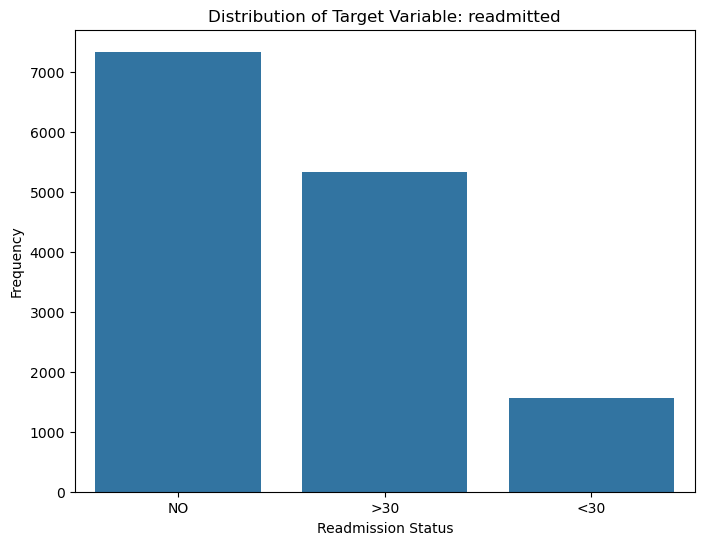

In [ ]:
# %%

if df_train_initial is not None:
    print("\n--- Target Variable Distribution ('readmitted') ---")
    print(df_train_initial['readmitted'].value_counts(normalize=True) * 100)
    
    plt.figure(figsize=(8, 6))
    sns.countplot(x='readmitted', data=df_train_initial, order=df_train_initial['readmitted'].value_counts().index)
    plt.title('Distribution of Target Variable: readmitted')
    plt.ylabel('Frequency')
    plt.xlabel('Readmission Status')
    plt.show()

# %% [markdown]

 ### 3.2. Initial Observations & Potential Cleaning Steps:

 *Based on the `.info()`, `.describe()`, and missing values output, we will note down initial observations here.*

 *   **Missing Values:** Columns like `weight`, `medical_specialty`, `payer_code` seem to have a high percentage of missing values. We'll need a strategy for these (e.g., imputation, creating a 'missing' category, or dropping if not useful/too sparse).
 *   **Data Types:** Ensure all columns have appropriate data types. Categorical features might be read as objects and may need explicit conversion to `category` type for efficiency and correct handling in some libraries.
 *   **Identifier Columns:** Columns like `encounter_id` and `patient_nbr` are likely identifiers and might not be useful as direct features for a predictive model but could be useful for tracking or joining data. `patient_nbr` is important because multiple encounters can belong to the same patient.
 *   **Categorical Features with Many Levels:** Some categorical columns might have a very large number of unique values (e.g., `diag_1`, `diag_2`, `diag_3`). This could lead to very high dimensionality if one-hot encoded directly. We might need to group them, use target encoding, or select top N categories.
 *   **Zero Variance / Near Zero Variance:** Check for columns with little to no variation as they won't be predictive.
 *   **Target Variable Imbalance:** The distribution of `readmitted` might be imbalanced, which could affect model training and evaluation. We might need techniques like oversampling, undersampling, or using appropriate metrics (e.g., F1-score, AUC-ROC).
 *   **Special Values:** The dataset description mentions 'Not Available', 'Not Mapped', '?' as special values in some columns. These need to be consistently handled (e.g., converted to `NaN`). `split_data.py` does not currently handle this explicitly for all columns during initial load, so it's something to check in the raw data if issues arise.

# %% [markdown]

 ## 4. Data Cleaning & Preprocessing (Initial Pass)

 Let's start with some basic cleaning based on the observations above.

In [ ]:
# %%

# Example: Replace ' ?' with NaN if it exists and wasn't handled earlier (though it should have been by pd.read_csv if it's a standard NA value)
# df_train_initial.replace('?', np.nan, inplace=True)

# We will add more cleaning steps here as we explore further.
print("Placeholder for initial data cleaning steps.")

Placeholder for initial data cleaning steps.


# %% [markdown]

 ---
 *Further EDA will involve looking at distributions of individual features, relationships between features and the target, and correlations.*
 ---

# %% [markdown]

 ### 3.3 Further Numerical Feature Exploration

Plotting histograms for: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


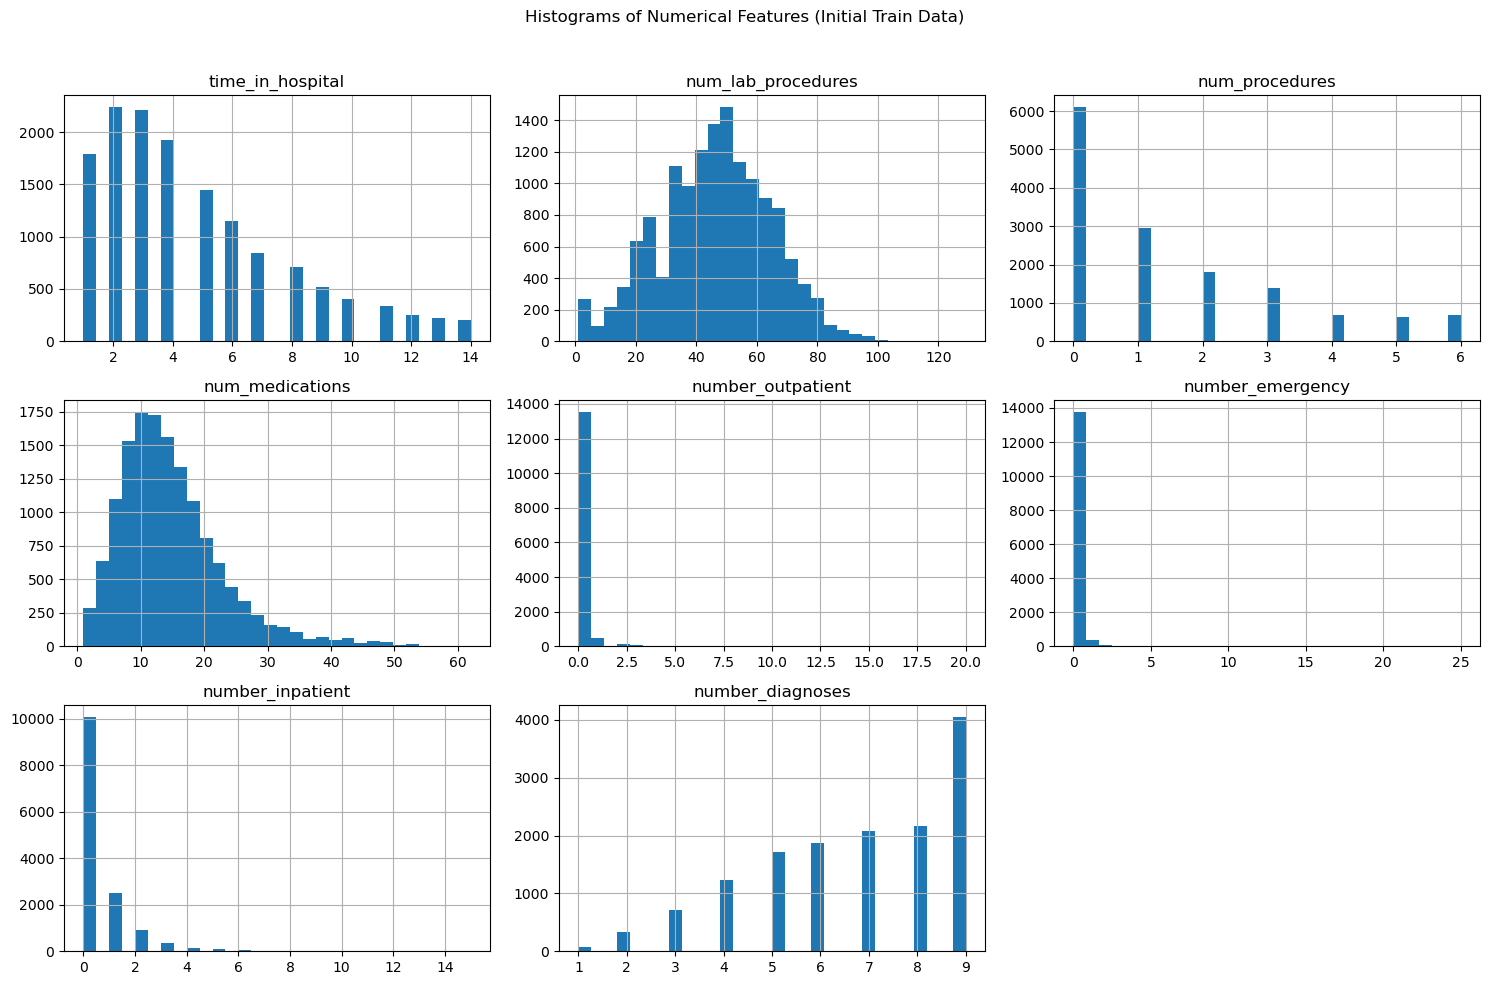

Plotting boxplots for: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


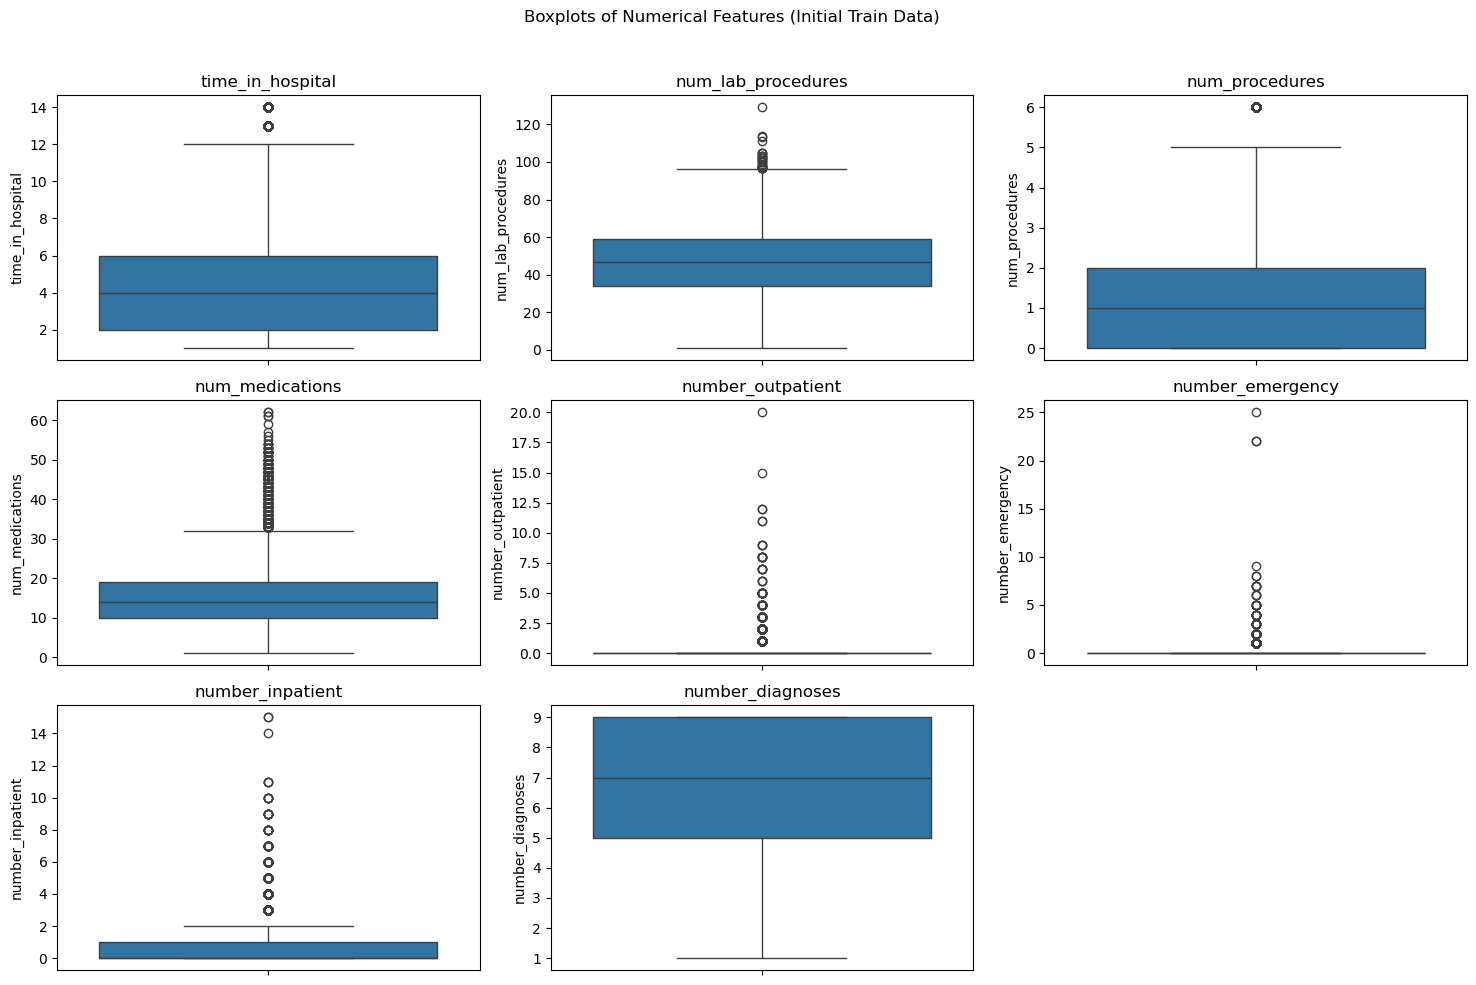

In [ ]:
# %%

if df_train_initial is not None:
    numerical_cols = df_train_initial.select_dtypes(include=np.number).columns.tolist()
    # Exclude identifier columns if they were loaded as numbers and not dropped yet
    # For now, assume encounter_id and patient_nbr are not in numerical_cols for plotting
    # Also excluding obviously categorical IDs that might be num_type by mistake
    # A proper list would be derived after confirming true numerical features
    plot_numerical_cols = [col for col in numerical_cols if col not in ['encounter_id', 'patient_nbr', 
                                                                    'admission_type_id', 'discharge_disposition_id', 
                                                                    'admission_source_id']] # Add other IDs if necessary
    
    if not plot_numerical_cols:
        print("No numerical columns selected for plotting after exclusions.")
    else:
        print(f"Plotting histograms for: {plot_numerical_cols}")
        df_train_initial[plot_numerical_cols].hist(bins=30, figsize=(15, 10), layout=(-1, 3))
        plt.suptitle("Histograms of Numerical Features (Initial Train Data)")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        print(f"Plotting boxplots for: {plot_numerical_cols}")
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(plot_numerical_cols):
            plt.subplot((len(plot_numerical_cols) + 2) // 3, 3, i + 1)
            sns.boxplot(y=df_train_initial[col])
            plt.title(col)
        plt.suptitle("Boxplots of Numerical Features (Initial Train Data)")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# %% [markdown]

 ### 3.4 Further Categorical Feature Exploration

Plotting barplots for: ['race', 'gender', 'age', 'weight', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


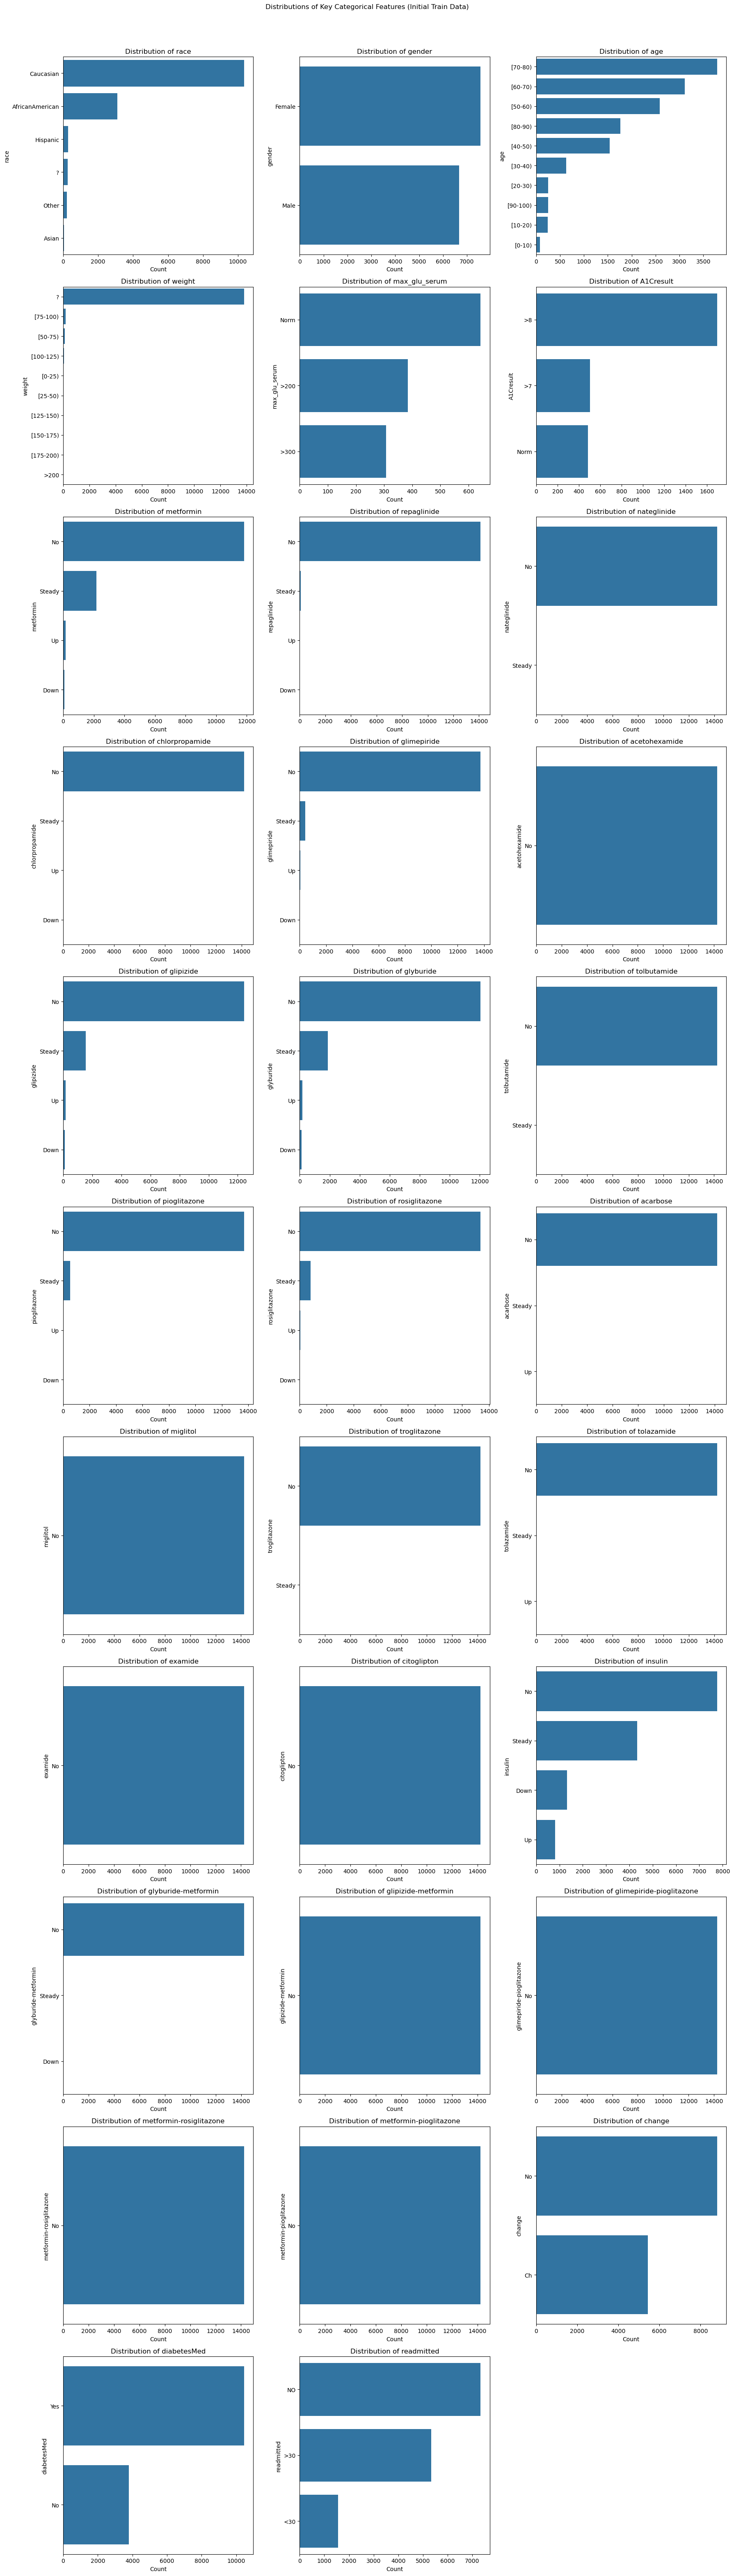

In [ ]:
# %%

if df_train_initial is not None:
    categorical_cols = df_train_initial.select_dtypes(include=['object', 'category']).columns.tolist()
    # Select a subset of categorical columns for plotting to avoid too many plots
    # Exclude high-cardinality features like diag_1, diag_2, diag_3 for now
    plot_categorical_cols = [col for col in categorical_cols if df_train_initial[col].nunique() < 25 and col not in ['diag_1', 'diag_2', 'diag_3', 'payer_code', 'medical_specialty']] 
    
    if not plot_categorical_cols:
        print("No categorical columns selected for plotting after exclusions/nunique filter.")
    else:
        print(f"Plotting barplots for: {plot_categorical_cols}")
        plt.figure(figsize=(18, len(plot_categorical_cols) * 2)) # Adjusted figure size
        for i, col in enumerate(plot_categorical_cols):
            plt.subplot((len(plot_categorical_cols) + 2) // 3, 3, i + 1)
            sns.countplot(y=df_train_initial[col], order=df_train_initial[col].value_counts().index)
            plt.title(f'Distribution of {col}')
            plt.xlabel('Count')
            plt.ylabel(col)
        plt.suptitle("Distributions of Key Categorical Features (Initial Train Data)")
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

# %% [markdown]

 ## 4. Data Cleaning & Preprocessing (Continued)

 Based on initial EDA, we'll perform cleaning and feature engineering.

# %% [markdown]

 ### 4.1 Handling '?' and Special Values

 Many datasets use '?' for missing values. We'll replace these with NaN.

In [ ]:
# %%

if df_train_initial is not None:
    # Create copies for cleaning to preserve original loaded data if needed for re-runs
    df_train_processed = df_train_initial.copy()
    
    # Replace '?' with NaN
    # Iterate through columns because df.replace('?', np.nan) might be slow on large mixed-type DFs
    # and can have unintended consequences if '?' is a valid category in some unknown column.
    # For this dataset, '?' is widely known as a missing value indicator.
    print("Replacing '?' with NaN globally...")
    for col in df_train_processed.columns:
        if df_train_processed[col].dtype == 'object':
            df_train_processed[col] = df_train_processed[col].replace('?', np.nan)
    
    # Verify '?' is gone from a sample column known to have them
    if 'race' in df_train_processed.columns:
      print(f"Value counts for 'race' after replacing '?':\n{df_train_processed['race'].value_counts(dropna=False)}")
    if 'payer_code' in df_train_processed.columns:
        print(f"Value counts for 'payer_code' after replacing '?':\n{df_train_processed['payer_code'].value_counts(dropna=False)}")
    if 'medical_specialty' in df_train_processed.columns:
        print(f"Value counts for 'medical_specialty' after replacing '?':\n{df_train_processed['medical_specialty'].value_counts(dropna=False)}")
else:
    print("df_train_initial is not loaded. Skipping cleaning.")
    df_train_processed = None

Replacing '?' with NaN globally...
Value counts for 'race' after replacing '?':
race
Caucasian          10352
AfricanAmerican     3103
Hispanic             279
NaN                  252
Other                209
Asian                 52
Name: count, dtype: int64
Value counts for 'payer_code' after replacing '?':
payer_code
NaN    14247
Name: count, dtype: int64
Value counts for 'medical_specialty' after replacing '?':
medical_specialty
NaN                                     5488
InternalMedicine                        2602
Family/GeneralPractice                  1792
Cardiology                              1162
Surgery-General                          458
Orthopedics-Reconstructive               295
Nephrology                               246
Orthopedics                              214
Psychiatry                               214
Pulmonology                              207
ObstetricsandGynecology                  193
Urology                                  183
Surgery-Cardiovascular

# %% [markdown]

 ### 4.2 Handling Missing Values (Based on EDA)

In [ ]:
# %%

if df_train_processed is not None:
    print("\n--- Initial Missing Values (Post '?' replacement) ---")
    missing_values_post_q = df_train_processed.isnull().sum()
    missing_percentage_post_q = (missing_values_post_q / len(df_train_processed)) * 100
    missing_info_post_q = pd.DataFrame({'Missing Count': missing_values_post_q, 'Missing Percentage': missing_percentage_post_q})
    print(missing_info_post_q[missing_info_post_q['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))

    # Strategy: Drop columns with very high missing percentage for baseline
    cols_to_drop_missing = []
    if 'weight' in df_train_processed.columns and (df_train_processed['weight'].isnull().sum() / len(df_train_processed)) > 0.9: # Example threshold 90%
        cols_to_drop_missing.append('weight')
    if 'payer_code' in df_train_processed.columns and (df_train_processed['payer_code'].isnull().sum() / len(df_train_processed)) > 0.4: # Example threshold 40%
        cols_to_drop_missing.append('payer_code')
    if 'medical_specialty' in df_train_processed.columns and (df_train_processed['medical_specialty'].isnull().sum() / len(df_train_processed)) > 0.4: # Example threshold 40%
        cols_to_drop_missing.append('medical_specialty')

    if cols_to_drop_missing:
        print(f"\nDropping columns due to high missing values: {cols_to_drop_missing}")
        df_train_processed.drop(columns=cols_to_drop_missing, inplace=True)
    
    # For remaining NaNs in categorical features like diag_1, diag_2, diag_3, race:
    # Impute with a "Missing" category or mode. For baseline, let's use "Missing".
    # This will be handled by OneHotEncoder later if they are still objects/categories.
    # For numerical columns, mean/median imputation might be used, but this dataset has few numerical features with missing values
    # after dropping 'weight'.
    
    # For simplicity in baseline, remaining NaNs in object/category columns will be treated as a separate category by OHE.
    # If any numerical columns had NaNs (other than those dropped), they'd need imputation (e.g., median).
    # Let's check again after drops:
    print("\n--- Missing Values After Dropping High-Missing Columns ---")
    missing_values_after_drop = df_train_processed.isnull().sum()
    missing_percentage_after_drop = (missing_values_after_drop / len(df_train_processed)) * 100
    missing_info_after_drop = pd.DataFrame({'Missing Count': missing_values_after_drop, 'Missing Percentage': missing_percentage_after_drop})
    print(missing_info_after_drop[missing_info_after_drop['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False))
    
    # For this dataset, 'race', 'diag_1', 'diag_2', 'diag_3' might still have NaNs.
    # We'll fill them with a placeholder string 'Missing'
    for col in ['race', 'diag_1', 'diag_2', 'diag_3']:
        if col in df_train_processed.columns and df_train_processed[col].isnull().any():
            print(f"Filling NaNs in '{col}' with 'Missing'")
            df_train_processed[col].fillna('Missing', inplace=True)

    print("\n--- Final Check for Missing Values ---")
    print(df_train_processed.isnull().sum().sum(), "total missing values remaining.")


--- Initial Missing Values (Post '?' replacement) ---
                   Missing Count  Missing Percentage
payer_code                 14247          100.000000
weight                     13815           96.967783
max_glu_serum              12913           90.636625
A1Cresult                  11562           81.153927
medical_specialty           5488           38.520390
diag_3                       413            2.898856
race                         252            1.768793
diag_2                        82            0.575560
diag_1                         6            0.042114

Dropping columns due to high missing values: ['weight', 'payer_code']

--- Missing Values After Dropping High-Missing Columns ---
                   Missing Count  Missing Percentage
max_glu_serum              12913           90.636625
A1Cresult                  11562           81.153927
medical_specialty           5488           38.520390
diag_3                       413            2.898856
race               

# %% [markdown]

 ### 4.3 Feature Engineering

In [ ]:
# %%

if df_train_processed is not None:
    # 1. Simplify Target Variable 'readmitted'
    #    NO -> 0 (Not Readmitted)
    #    <30, >30 -> 1 (Readmitted)
    print("\n--- Simplifying Target Variable 'readmitted' ---")
    df_train_processed['readmitted_binary'] = df_train_processed['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)
    print(df_train_processed['readmitted_binary'].value_counts(normalize=True))
    
    # 2. Process 'age' column: '[70-80)' -> 75 (midpoint) or ordinal
    # Using ordinal for simplicity and to maintain order
    print("\n--- Processing 'age' column ---")
    if 'age' in df_train_processed.columns:
        age_mapping = {
            '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4,
            '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9
        }
        df_train_processed['age_ordinal'] = df_train_processed['age'].map(age_mapping)
        print(df_train_processed[['age', 'age_ordinal']].head())
    
    # 3. Drop original 'readmitted' and 'age' columns, and identifiers
    cols_to_drop_engineered = ['readmitted', 'age', 'encounter_id', 'patient_nbr']
    # Also drop diag_1, diag_2, diag_3 for baseline simplicity due to high cardinality and complexity of encoding them properly
    # A more advanced approach would involve feature engineering on these.
    cols_to_drop_engineered.extend(['diag_1', 'diag_2', 'diag_3'])

    existing_cols_to_drop = [col for col in cols_to_drop_engineered if col in df_train_processed.columns]
    print(f"\nDropping columns: {existing_cols_to_drop}")
    df_train_processed.drop(columns=existing_cols_to_drop, inplace=True)
    
    print("\n--- DataFrame after initial Feature Engineering ---")
    print(df_train_processed.head())
    df_train_processed.info()


--- Simplifying Target Variable 'readmitted' ---
readmitted_binary
0    0.515407
1    0.484593
Name: proportion, dtype: float64

--- Processing 'age' column ---
       age  age_ordinal
0   [0-10)            0
1  [10-20)            1
2  [20-30)            2
3  [30-40)            3
4  [40-50)            4

Dropping columns: ['readmitted', 'age', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3']

--- DataFrame after initial Feature Engineering ---
              race  gender  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital         medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepir

# %% [markdown]

 ## 5. Preprocessing for Modeling

 - Identify categorical and numerical features.
 - Apply One-Hot Encoding to categorical features and Scaling to numerical features.

In [ ]:
# %%

if df_train_processed is not None:
    y_train = df_train_processed['readmitted_binary']
    X_train = df_train_processed.drop(columns=['readmitted_binary'])

    # Identify categorical and numerical columns
    # Ensure 'id' columns that are actually categorical are treated as such
    # For this dataset, many columns like 'admission_type_id' are categorical despite being numbers
    # A full list based on dataset description would be ideal. For now, an approximation:
    potential_categorical_ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'] # Add others if known
    
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    for col_id in potential_categorical_ids:
        if col_id in X_train.columns and X_train[col_id].dtype != 'object' and X_train[col_id].dtype != 'category':
            if X_train[col_id].nunique() < 30: # Heuristic for ID-like categoricals
                 categorical_features.append(col_id)
                 X_train[col_id] = X_train[col_id].astype('category')


    numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
    # Remove any numerical features that were re-classified as categorical (like age_ordinal if we want to OHE it, but we'll scale it)
    # or actual categorical_ids that were numeric
    numerical_features = [col for col in numerical_features if col not in categorical_features]
    if 'age_ordinal' in numerical_features: # Keep age_ordinal as numerical for scaling
        pass
    
    # Ensure no overlap and all columns are covered
    categorical_features = list(set(categorical_features)) # Deduplicate
    processed_cols = set(categorical_features + numerical_features)
    all_cols = set(X_train.columns)
    if processed_cols != all_cols:
        print(f"Warning: Column mismatch. Untracked columns: {all_cols - processed_cols}")
        print(f"All: {all_cols}, Processed: {processed_cols}")
        # For any remaining, classify as categorical if object, else numerical
        for rem_col in (all_cols - processed_cols):
            if X_train[rem_col].dtype == 'object':
                categorical_features.append(rem_col)
            else:
                numerical_features.append(rem_col)
        categorical_features = list(set(categorical_features))
        numerical_features = list(set(numerical_features) - set(categorical_features))


    print(f"\nIdentified Numerical Features: {numerical_features}")
    print(f"Identified Categorical Features: {categorical_features}")

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
        ], 
        remainder='passthrough' # Should be empty if all cols are covered
    )

    # Fit and transform the training data
    print("\nFitting preprocessor and transforming training data...")
    X_train_prepared = preprocessor.fit_transform(X_train)
    
    # Get feature names after OHE for creating a DataFrame (optional, but good for inspection)
    try:
        ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
        all_feature_names = numerical_features + ohe_feature_names.tolist()
        X_train_prepared_df = pd.DataFrame(X_train_prepared.toarray() if hasattr(X_train_prepared, "toarray") else X_train_prepared, columns=all_feature_names) # .toarray() for sparse matrix
        print(f"Training data transformed. Shape: {X_train_prepared_df.shape}")
        print(X_train_prepared_df.head())
    except Exception as e:
        print(f"Could not get OHE feature names or create DataFrame: {e}")
        print(f"Training data transformed (sparse matrix). Shape: {X_train_prepared.shape}")


    # Preprocess Validation and Test data
    print("\nLoading and preprocessing validation and test data...")
    df_val_initial = load_df_from_s3(S3_BUCKET_NAME, INITIAL_VALIDATION_KEY, s3_client)
    df_test_initial = load_df_from_s3(S3_BUCKET_NAME, INITIAL_TEST_KEY, s3_client)

    X_val_prepared = None
    y_val = None
    X_test_prepared = None
    y_test = None

    if df_val_initial is not None:
        df_val_processed = df_val_initial.copy()
        for col in df_val_processed.columns: # Replace '?'
            if df_val_processed[col].dtype == 'object':
                df_val_processed[col] = df_val_processed[col].replace('?', np.nan)
        if cols_to_drop_missing: # Drop same high-missing columns
            df_val_processed.drop(columns=[col for col in cols_to_drop_missing if col in df_val_processed.columns], inplace=True)
        for col in ['race', 'diag_1', 'diag_2', 'diag_3']: # Fill NaNs
            if col in df_val_processed.columns: df_val_processed[col].fillna('Missing', inplace=True)
        
        df_val_processed['readmitted_binary'] = df_val_processed['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)
        if 'age' in df_val_processed.columns:
             df_val_processed['age_ordinal'] = df_val_processed['age'].map(age_mapping)
        existing_cols_to_drop_val = [col for col in cols_to_drop_engineered if col in df_val_processed.columns]
        df_val_processed.drop(columns=existing_cols_to_drop_val, inplace=True)
        
        y_val = df_val_processed['readmitted_binary']
        X_val = df_val_processed.drop(columns=['readmitted_binary'])
        for col_id in potential_categorical_ids: # Ensure cat type for IDs
            if col_id in X_val.columns and X_val[col_id].dtype != 'object' and X_val[col_id].dtype != 'category':
                 X_val[col_id] = X_val[col_id].astype('category')
        
        X_val_prepared = preprocessor.transform(X_val)
        print(f"Validation data transformed. Shape: {X_val_prepared.shape}")

    if df_test_initial is not None:
        df_test_processed = df_test_initial.copy()
        for col in df_test_processed.columns: # Replace '?'
             if df_test_processed[col].dtype == 'object':
                df_test_processed[col] = df_test_processed[col].replace('?', np.nan)
        if cols_to_drop_missing: # Drop same high-missing columns
            df_test_processed.drop(columns=[col for col in cols_to_drop_missing if col in df_test_processed.columns], inplace=True)
        for col in ['race', 'diag_1', 'diag_2', 'diag_3']: # Fill NaNs
            if col in df_test_processed.columns: df_test_processed[col].fillna('Missing', inplace=True)

        df_test_processed['readmitted_binary'] = df_test_processed['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)
        if 'age' in df_test_processed.columns:
            df_test_processed['age_ordinal'] = df_test_processed['age'].map(age_mapping)
        existing_cols_to_drop_test = [col for col in cols_to_drop_engineered if col in df_test_processed.columns]
        df_test_processed.drop(columns=existing_cols_to_drop_test, inplace=True)

        y_test = df_test_processed['readmitted_binary']
        X_test = df_test_processed.drop(columns=['readmitted_binary'])
        for col_id in potential_categorical_ids: # Ensure cat type for IDs
            if col_id in X_test.columns and X_test[col_id].dtype != 'object' and X_test[col_id].dtype != 'category':
                 X_test[col_id] = X_test[col_id].astype('category')

        X_test_prepared = preprocessor.transform(X_test)
        print(f"Test data transformed. Shape: {X_test_prepared.shape}")


Identified Numerical Features: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_ordinal']
Identified Categorical Features: ['gender', 'metformin', 'miglitol', 'examide', 'admission_type_id', 'discharge_disposition_id', 'insulin', 'chlorpropamide', 'admission_source_id', 'glyburide-metformin', 'max_glu_serum', 'glimepiride-pioglitazone', 'glimepiride', 'repaglinide', 'diabetesMed', 'change', 'acarbose', 'metformin-pioglitazone', 'tolbutamide', 'glyburide', 'pioglitazone', 'A1Cresult', 'citoglipton', 'glipizide-metformin', 'medical_specialty', 'tolazamide', 'acetohexamide', 'nateglinide', 'troglitazone', 'race', 'metformin-rosiglitazone', 'glipizide', 'rosiglitazone']

Fitting preprocessor and transforming training data...
Training data transformed. Shape: (14247, 134)
   time_in_hospital  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emer

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 5, 9, 24, 27] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# %% [markdown]

 ## 6. Train Baseline Model (Logistic Regression)

In [ ]:
# %%

baseline_model = None
if X_train_prepared is not None and y_train is not None:
    print("\n--- Training Baseline Model (Logistic Regression) ---")
    baseline_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced') # class_weight for imbalance
    baseline_model.fit(X_train_prepared, y_train)
    print("Baseline model trained.")
else:
    print("Training data not prepared. Skipping model training.")


--- Training Baseline Model (Logistic Regression) ---
Baseline model trained.


# %% [markdown]

 ## 7. Evaluate Baseline Model


--- Evaluating Baseline Model on Test Set ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1753
           1       0.56      0.65      0.60      1300

    accuracy                           0.63      3053
   macro avg       0.63      0.63      0.63      3053
weighted avg       0.64      0.63      0.63      3053

Accuracy Score (Test Set):
0.631837536849001

Confusion Matrix (Test Set):


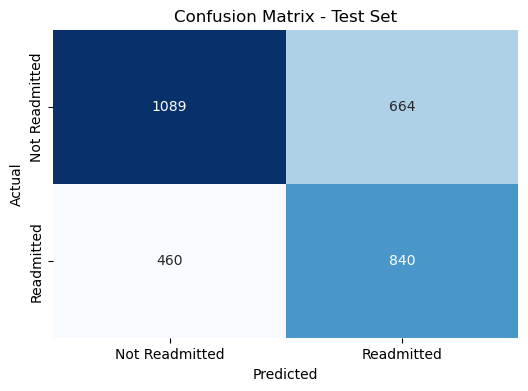

In [ ]:
# %%

if baseline_model is not None and X_test_prepared is not None and y_test is not None:
    print("\n--- Evaluating Baseline Model on Test Set ---")
    y_pred_test = baseline_model.predict(X_test_prepared)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))
    
    print("Accuracy Score (Test Set):")
    print(accuracy_score(y_test, y_pred_test))
    
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Readmitted', 'Readmitted'], 
                yticklabels=['Not Readmitted', 'Readmitted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Test Set')
    plt.show()
else:
    print("Model not trained or test data not prepared. Skipping evaluation.")

# %% [markdown]

 ## 8. Observations, Conclusions & Next Steps

 *   **EDA Summary:** Briefly summarize key findings from EDA (missing values, important features noted, target distribution).
 *   **Data Quality Issues:** Note any significant data quality problems (e.g., high cardinality in `diag` codes, extensive missingness in `weight`, `payer_code`, `medical_specialty`). The decision to drop `diag_1,2,3` for the baseline simplifies things but loses potentially valuable info.
 *   **Baseline Model Performance:** Discuss the performance of Logistic Regression. Is it better than random chance? What do precision/recall for each class indicate, especially given potential class imbalance?
 *   **Limitations of Baseline:**
     *   Simple feature engineering (e.g., ordinal for age, dropping complex categoricals like diagnoses).
     *   Basic missing value handling (dropping columns, 'Missing' category).
     *   Only one model tried, no hyperparameter tuning.
     *   Class imbalance potentially not fully addressed by `class_weight='balanced'` alone.
 *   **Recommendations for Next Iterations:**
     *   More sophisticated feature engineering for `diag_1, diag_2, diag_3` (e.g., grouping into broader categories, using embeddings if applicable, or target encoding with care).
     *   Explore imputation techniques for moderately missing features instead of dropping or just using 'Missing'.
     *   Try other models (e.g., Random Forest, Gradient Boosting).
     *   Perform hyperparameter tuning (e.g., using GridSearchCV or RayTune as planned for later).
     *   Address class imbalance more robustly (e.g., SMOTE, ADASYN for oversampling, or different model cost functions).
     *   Feature selection techniques.
     *   Deeper investigation into `patient_nbr` to see if features about prior visits for the same patient could be engineered (though this adds complexity for a baseline).
     *   Log experiments with MLflow.

# %% [markdown]

 ---
 End of Initial EDA and Baseline Model Script.
 Remember to commit this script to Git.
 Consider stopping the EC2 instance if not actively using it to save costs.
 ---